/tmp/ipykernel_233604/446387276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_node['_ts'] = pd.to_datetime(data_node['_ts'])


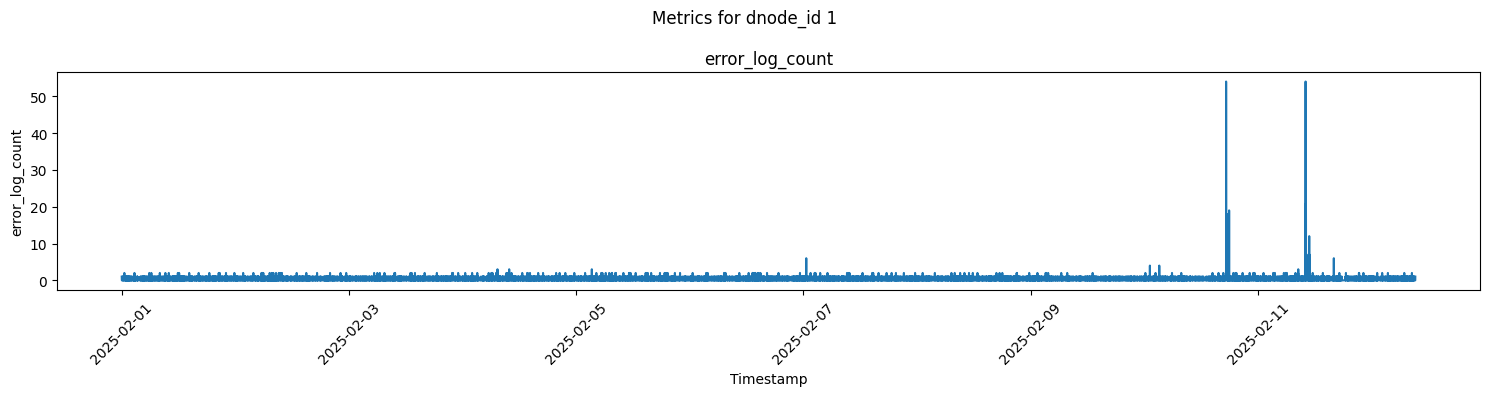

/tmp/ipykernel_233604/446387276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_node['_ts'] = pd.to_datetime(data_node['_ts'])


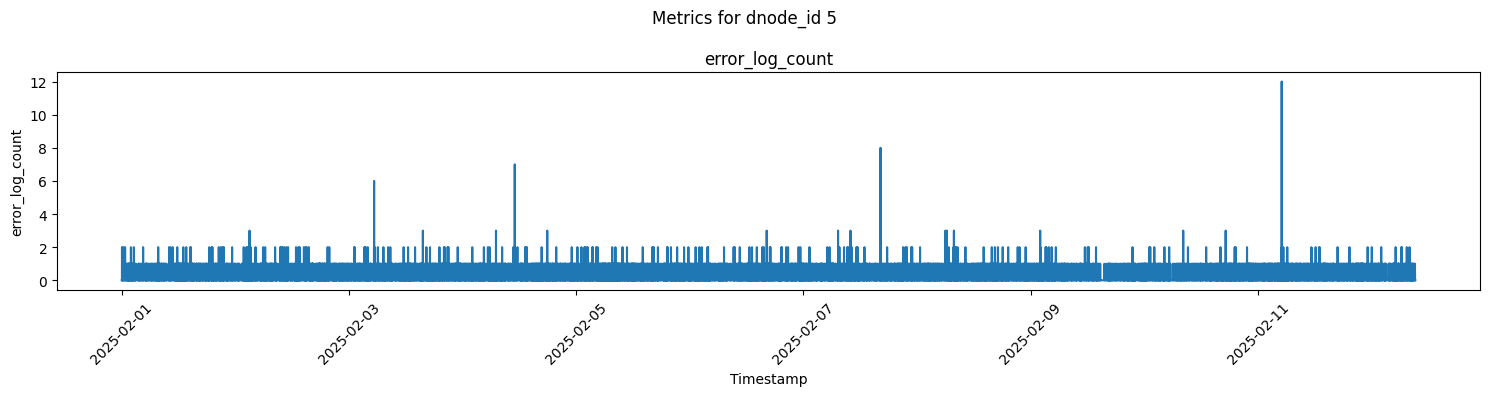

/tmp/ipykernel_233604/446387276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_node['_ts'] = pd.to_datetime(data_node['_ts'])


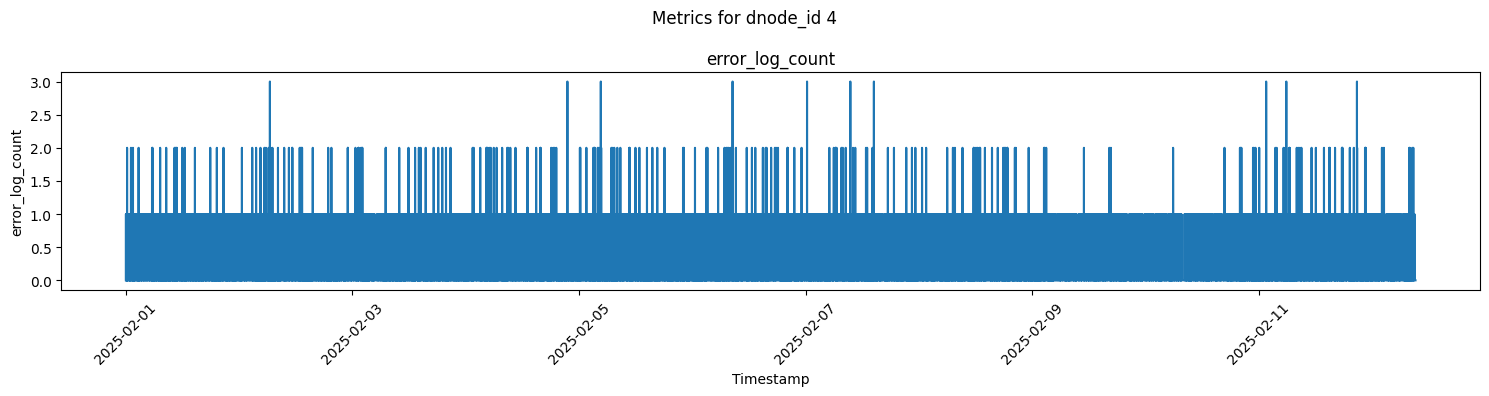

/tmp/ipykernel_233604/446387276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_node['_ts'] = pd.to_datetime(data_node['_ts'])


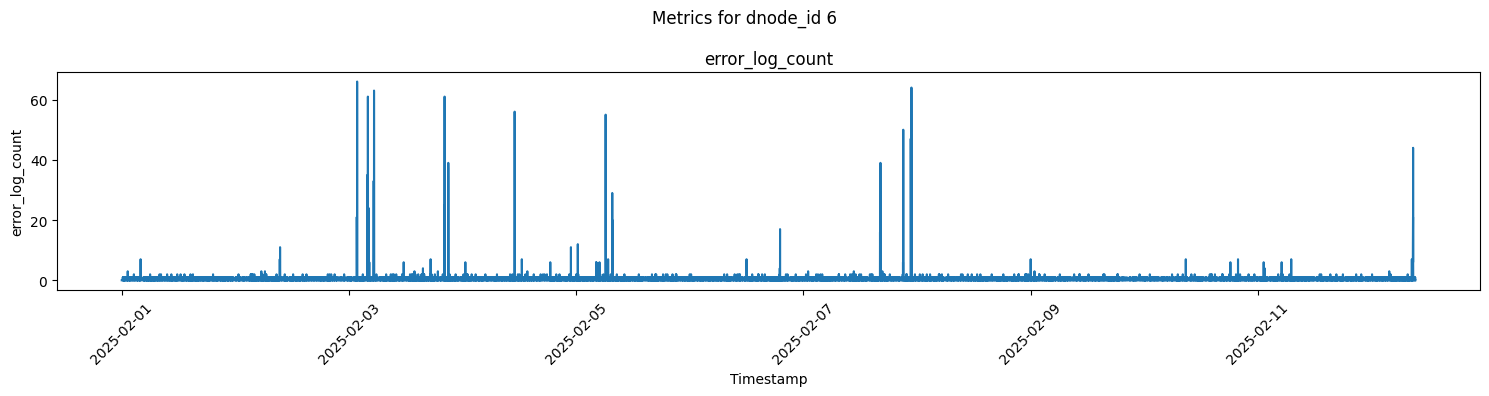

/tmp/ipykernel_233604/446387276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_node['_ts'] = pd.to_datetime(data_node['_ts'])


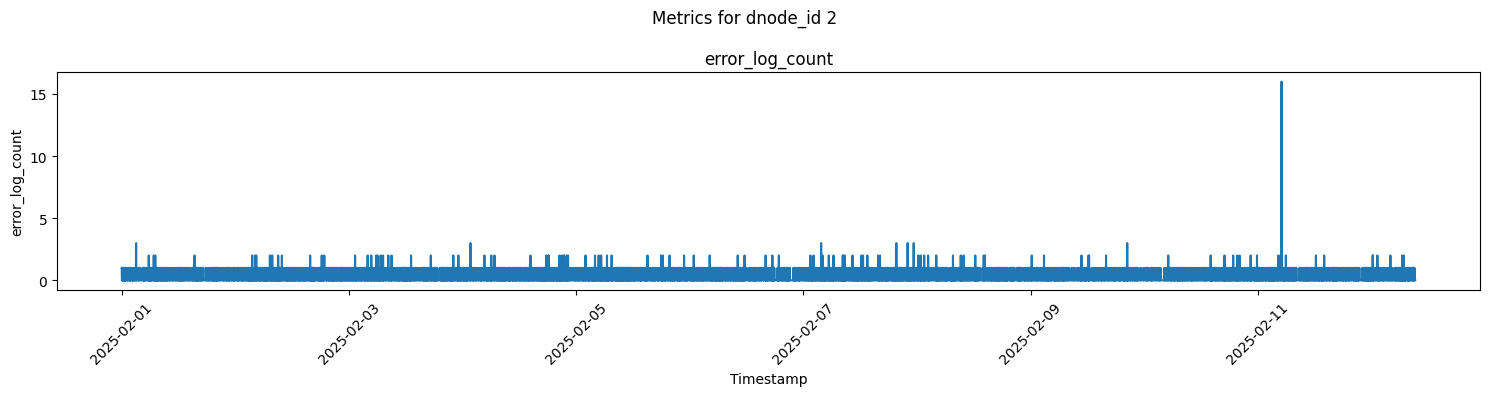

/tmp/ipykernel_233604/446387276.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_node['_ts'] = pd.to_datetime(data_node['_ts'])


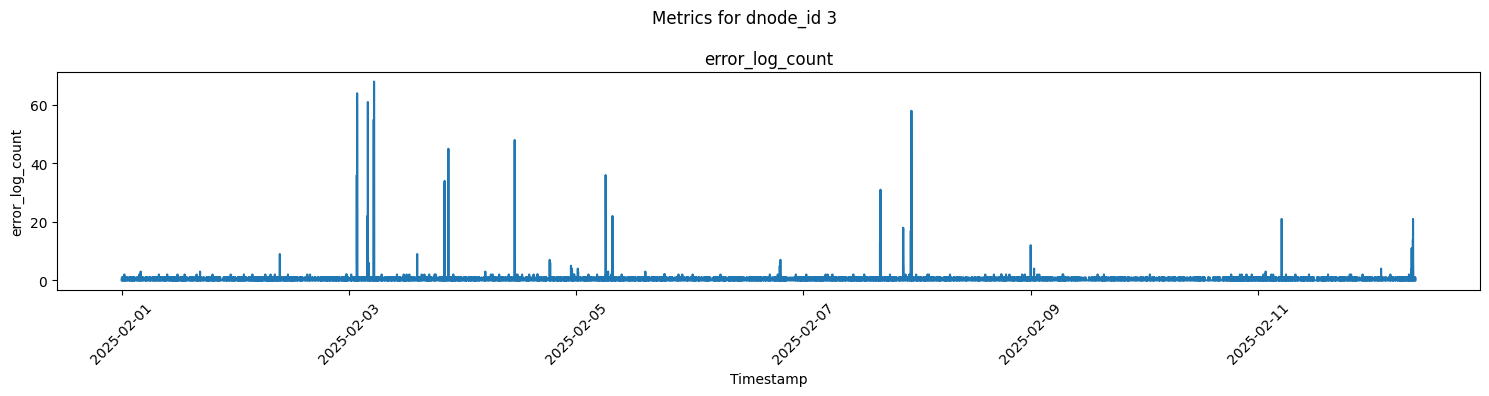

In [18]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_data(data, dnode_id):
    data_node = data[(data['dnode_id'] == dnode_id) & (data['_ts'] >= '2025-02-01')]
    # metrics = [col for col in data.columns if col not in [
    #     '_ts', 'dnode_id', 'disk_engine', 'vnodes_num', 'has_mnode', 'cpu_cores', 'has_qnode', 'has_snode', 'disk_total', 'mem_total', 'cluster_id',
    #     'trace_log_count', 'debug_log_count', 'dnode_ep', 'uptime', 'info_log_count', 'masters']]
    metrics = [col for col in data.columns if col in ['error_log_count']]
    n_metrics = len(metrics)

    # Calculate number of rows and columns for subplots
    n_rows = (n_metrics + 2) // 3  # 3 columns
    n_cols = min(3, n_metrics)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    fig.suptitle(f'Metrics for dnode_id {dnode_id}')

    # Convert timestamp once for all plots
    data_node['_ts'] = pd.to_datetime(data_node['_ts'])

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if n_metrics > 1 else [axes]

    for idx, (metric, ax) in enumerate(zip(metrics, axes_flat)):
        ax.plot(data_node['_ts'], data_node[metric])
        ax.set_title(metric)
        ax.set_xlabel('Timestamp')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)

    # Hide empty subplots if any
    for idx in range(len(metrics), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    plt.tight_layout()
    return fig


# Read the data
data = pd.read_csv("/root/workspace/support/hbdl/dnode_info_0101_0212.csv")

# Plot for each unique dnode_id
for dnode_id in data['dnode_id'].unique():
    fig = plot_data(data, dnode_id)
    plt.show()

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt  # Fix: import pyplot directly


def ana_log_line(line):
    line = line.strip().split()
    timestamp = line[0] + ' ' + line[1]
    timestamp_dt = datetime.strptime(timestamp, '%m/%d %H:%M:%S.%f').replace(year=datetime.now().year)
    if timestamp_dt > datetime.now():
        timestamp_dt = timestamp_dt.replace(year=datetime.now().year - 1)
    timestamp = int(timestamp_dt.timestamp() * 1_000_000)
    vgroup_id = int(line[5].strip(',').split(':')[1])
    return timestamp, vgroup_id


if __name__ == "__main__":
    dnode_ids = np.arange(1, 7)
    results = pd.DataFrame(columns=['dnode_id', 'vgroup_id', 'action', 'start_time', 'elapsed_time'])

    for dnode_id in dnode_ids:
        print(f'start to process dnode {dnode_id}')
        log_dir = f'/root/workspace/support/hbdl/dnode{dnode_id}/'
        track_map = {}
        try:
            f = open(log_dir + 'taosdlog.0', 'r')
        except FileNotFoundError:
            f = open(log_dir + 'taosdlog.1', 'r')
        
        for line in f:
            if 'start to commit' in line:
                ts, vgroup_id = ana_log_line(line)
                track_map[f'commit-{vgroup_id}'] = ts
            elif 'commit end' in line:
                ts, vgroup_id = ana_log_line(line)
                if f'commit-{vgroup_id}' in track_map:
                    elapsed_time = (ts - track_map[f'commit-{vgroup_id}']) / 1000000
                    new_row = pd.DataFrame([{'dnode_id': dnode_id, 'vgroup_id': vgroup_id, 'action': 'commit','start_time': track_map[f'commit-{vgroup_id}'], 'elapsed_time': elapsed_time}])
                    results = pd.concat([results, new_row], ignore_index=True)
                    del track_map[f'commit-{vgroup_id}']
            elif 'merge begin' in line:
                ts, vgroup_id = ana_log_line(line)
                track_map[f'merge-{vgroup_id}'] = ts
            elif 'merge done' in line:
                ts, vgroup_id = ana_log_line(line)
                if f'merge-{vgroup_id}' in track_map:
                    elapsed_time = (ts - track_map[f'merge-{vgroup_id}']) / 1000000
                    new_row = pd.DataFrame([{'dnode_id': dnode_id, 'vgroup_id': vgroup_id, 'action':'merge', 'start_time': track_map[f'merge-{vgroup_id}'], 'elapsed_time': elapsed_time}])
                    results = pd.concat([results, new_row], ignore_index=True)
                    del track_map[f'merge-{vgroup_id}']

        f.close()
    
    results.to_csv('results.csv', index=False)

    # # Convert microsecond timestamp to readable datetime
    # results['start_time'] = pd.to_datetime(results['start_time'], unit='us')
    # plot_results(results, 1)

start to process dnode 1


/tmp/ipykernel_243005/1533141027.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


start to process dnode 2
start to process dnode 3
start to process dnode 4
start to process dnode 5
start to process dnode 6


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt  # Fix: import pyplot directly

def plot_dnode_vgroup_results(results, dnode_id, vgroup_id, time_range):
    start_time, end_time = time_range
    results = results[(results['dnode_id'] == dnode_id) & (results['vgroup_id'] == vgroup_id) & (results['start_time'] >= start_time) & (results['start_time'] <= end_time)]
    plt.figure(figsize=(12, 6))
    plt.scatter(results['start_time'], results['elapsed_time'])
    plt.title(f'Dnode {dnode_id}:{vgroup_id} Elapsed Time Scatter Plot')
    plt.xlabel('Start Time')
    plt.ylabel('Elapsed Time (s)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

def plot_vgroup_results(results, vgroup_id, time_range):
    results = results[results['vgroup_id'] == vgroup_id]
    for dnode_id in results['dnode_id'].unique():
        plot_dnode_vgroup_results(results, dnode_id, vgroup_id, time_range)
    

if __name__ == '__main__':
    results = pd.read_csv('results.csv')
    results = results[results['action'] == 'commit']
    # results = results[results['action'] == 'merge']
    results['start_time'] = pd.to_datetime(results['start_time'], unit='us')
    time_range = [datetime(2025, 2, 1), datetime.now()]
    vgroup_ids = results['vgroup_id'].unique()
    for vgroup_id in vgroup_ids:
        if vgroup_id < 90:
            continue
        plot_vgroup_results(results, vgroup_id, time_range)
    



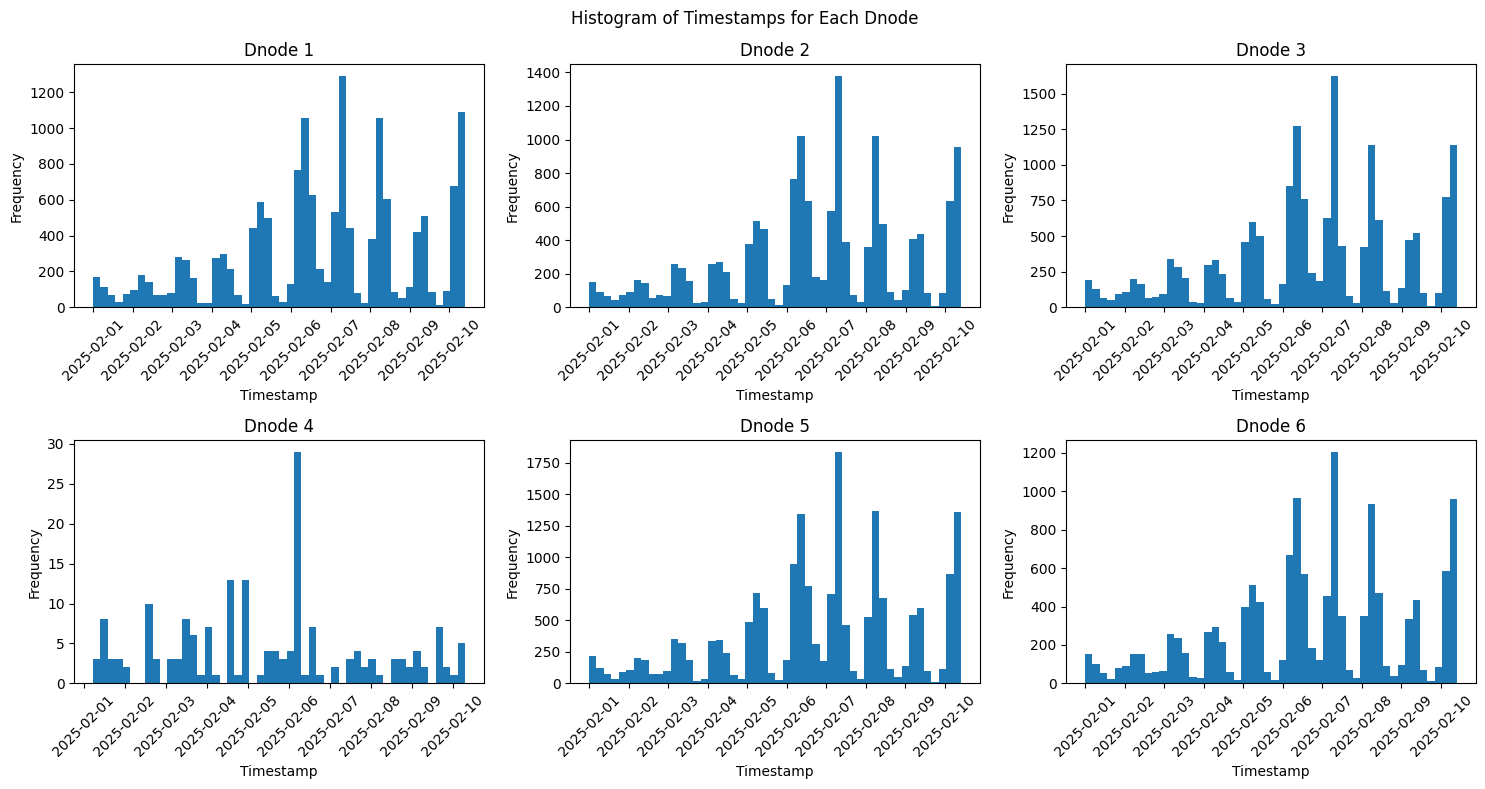

In [ ]:
import pandas as pd
import os

if __name__ == '__main__':
    if not os.path.exists('scan_result.csv'):
        pattern = "has been queued for too long"
        results = pd.DataFrame(columns=['timestamp', 'dnode_id'])


        for dnode_id in range(1, 7):
            print(f"Start to process dnode {dnode_id}")
            log_dir = f'/root/workspace/support/hbdl/dnode{dnode_id}/'
            try:
                f = open(log_dir + 'taosdlog.0', 'r')
            except FileNotFoundError:
                f = open(log_dir + 'taosdlog.1', 'r')
            
            for line in f:
                if pattern in line:
                    timestamp_dt = datetime.strptime(' '.join(line.strip().split()[:2]), '%m/%d %H:%M:%S.%f').replace(year=datetime.now().year)
                    if timestamp_dt > datetime.now():
                        timestamp_dt = timestamp_dt.replace(year=datetime.now().year - 1)
                    timestamp = int(timestamp_dt.timestamp() * 1_000_000)

                    new_row = pd.DataFrame([{'timestamp': timestamp, 'dnode_id': dnode_id}])
                    results = pd.concat([results, new_row], ignore_index=True)
            
            f.close()

        results.to_csv('scan_result.csv', index=False)
    else:
        results = pd.read_csv('scan_result.csv')
    
    # Convert timestamp to datetime for plotting
    results['timestamp'] = pd.to_datetime(results['timestamp'], unit='us')

    # Filter data from 2025-02-01 to now
    start_date = datetime(2025, 2, 1)
    results = results[results['timestamp'] >= start_date]

    # Get unique dnode_ids

    # Calculate number of rows and columns for subplots
    n_rows = (len(unique_dnode_ids) + 2) // 3  # 3 columns
    n_cols = min(3, len(unique_dnode_ids))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    fig.suptitle('Histogram of Timestamps for Each Dnode')

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if len(unique_dnode_ids) > 1 else [axes]

    for idx, (dnode_id, ax) in enumerate(zip(unique_dnode_ids, axes_flat)):
        dnode_data = results[results['dnode_id'] == dnode_id]
        ax.hist(dnode_data['timestamp'], bins=50)
        ax.set_title(f'Dnode {dnode_id}')
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)

    # Hide empty subplots if any
    for idx in range(len(unique_dnode_ids), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    plt.tight_layout()
    plt.show()


In [12]:
from IPython.display import display

html_str = """
<!DOCTYPE html>
<html lang="en">
<head>
  <title>Bootstrap Example</title>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
  <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"></script>
</head>
<body>

<div class="container mt-3">
  <h2>Multiple Progress Bars</h2>
  <p>Create a stacked progress bar by placing multiple bars into the same div with class="progress":</p> 
  <div class="progress">
    <div class="progress-bar bg-success" style="width:40%">
      Free Space
    </div>
    <div class="progress-bar bg-warning" style="width:10%">
      Warning
    </div>
    <div class="progress-bar bg-danger" style="width:20%">
      Danger
    </div>
  </div>
</div>

</body>
</html>
"""

display(html_str)

'\n<!DOCTYPE html>\n<html lang="en">\n<head>\n  <title>Bootstrap Example</title>\n  <meta charset="utf-8">\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">\n  <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"></script>\n</head>\n<body>\n\n<div class="container mt-3">\n  <h2>Multiple Progress Bars</h2>\n  <p>Create a stacked progress bar by placing multiple bars into the same div with class="progress":</p> \n  <div class="progress">\n    <div class="progress-bar bg-success" style="width:40%">\n      Free Space\n    </div>\n    <div class="progress-bar bg-warning" style="width:10%">\n      Warning\n    </div>\n    <div class="progress-bar bg-danger" style="width:20%">\n      Danger\n    </div>\n  </div>\n</div>\n\n</body>\n</html>\n'

In [ ]:
import psutil
import time
import pandas as pd
from datetime import datetime
import os

def get_system_metrics():
    cpu = psutil.cpu_percent(interval=1)
    mem = psutil.virtual_memory().percent
    disk = psutil.disk_usage('/').percent
    net = psutil.net_io_counters()
    return {
        'timestamp': datetime.now(),
        'cpu_percent': cpu,
        'memory_percent': mem,
        'disk_percent': disk,
        'bytes_sent': net.bytes_sent,
        'bytes_recv': net.bytes_recv
    }

def monitor():
    data = []
    last_save = time.time()
    
    # Set up the plot
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    fig.suptitle('System Metrics Monitoring')
    plt.ion()  # Enable interactive mode
    
    # Initialize empty lists for plotting
    times = []
    cpu_data = []
    mem_data = []
    disk_data = []
    net_sent_data = []
    net_recv_data = []
    
    while True:
        metrics = get_system_metrics()
        data.append(metrics)
        
        # Update plot data
        times.append(metrics['timestamp'])
        cpu_data.append(metrics['cpu_percent'])
        mem_data.append(metrics['memory_percent'])
        disk_data.append(metrics['disk_percent'])
        net_sent_data.append(metrics['bytes_sent'])
        net_recv_data.append(metrics['bytes_recv'])
        
        # Keep only last 60 points (1 minute of data)
        if len(times) > 60:
            times = times[-60:]
            cpu_data = cpu_data[-60:]
            mem_data = mem_data[-60:]
            disk_data = disk_data[-60:]
            net_sent_data = net_sent_data[-60:]
            net_recv_data = net_recv_data[-60:]
        
        # Clear and update plots
        for ax in axs.flat:
            ax.clear()
            
        axs[0,0].plot(times, cpu_data, 'b-')
        axs[0,0].set_title('CPU Usage (%)')
        
        axs[0,1].plot(times, mem_data, 'r-')
        axs[0,1].set_title('Memory Usage (%)')
        
        axs[1,0].plot(times, disk_data, 'g-')
        axs[1,0].set_title('Disk Usage (%)')
        
        axs[1,1].plot(times, net_sent_data, 'y-')
        axs[1,1].set_title('Network Bytes Sent')
        
        axs[2,0].plot(times, net_recv_data, 'm-')
        axs[2,0].set_title('Network Bytes Received')
        
        # Rotate x-axis labels
        for ax in axs.flat:
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.draw()
        plt.pause(0.1)
        
        # Save to CSV every 10 minutes
        if

if __name__ == "__main__":
    monitor()

{'timestamp': datetime.datetime(2025, 2, 13, 10, 3, 23, 963126), 'cpu_percent': 2.1, 'memory_percent': 19.8, 'disk_percent': 24.8, 'bytes_sent': 135374524921, 'bytes_recv': 136336087131}
{'timestamp': datetime.datetime(2025, 2, 13, 10, 3, 25, 965274), 'cpu_percent': 2.1, 'memory_percent': 19.8, 'disk_percent': 24.8, 'bytes_sent': 135374564488, 'bytes_recv': 136336126698}
{'timestamp': datetime.datetime(2025, 2, 13, 10, 3, 27, 968098), 'cpu_percent': 1.9, 'memory_percent': 19.8, 'disk_percent': 24.8, 'bytes_sent': 135374609648, 'bytes_recv': 136336171990}
{'timestamp': datetime.datetime(2025, 2, 13, 10, 3, 29, 972266), 'cpu_percent': 2.3, 'memory_percent': 19.8, 'disk_percent': 24.8, 'bytes_sent': 135374657917, 'bytes_recv': 136336220259}
{'timestamp': datetime.datetime(2025, 2, 13, 10, 3, 31, 976284), 'cpu_percent': 1.6, 'memory_percent': 19.8, 'disk_percent': 24.8, 'bytes_sent': 135374698404, 'bytes_recv': 136336260746}
{'timestamp': datetime.datetime(2025, 2, 13, 10, 3, 33, 978143), 

KeyboardInterrupt: 